In [0]:
import torch
import torchvision
import torchvision.transforms as transforms


import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import sys
sys.path.append('/content/drive/My Drive/EVA/S7')

In [0]:
import albumentations as A
from evaAlbumentations import AlbumentationTransforms
import numpy as np
means = (0.485, 0.456, 0.406)
stdevs = (0.229, 0.224, 0.225)
train_transforms = AlbumentationTransforms(
    [ A.PadIfNeeded(40,40),
      A.RandomCrop(32, 32),
      A.HorizontalFlip(),
      A.Normalize(mean=means, std=stdevs),
      A.Cutout(num_holes=8)])




test_transforms = AlbumentationTransforms([A.Normalize(mean=means, std=stdevs)])

In [5]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=train_transforms)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=test_transforms)

Files already downloaded and verified
Files already downloaded and verified


In [0]:
import evadataloader
dataloader = evadataloader.DataLoader()

trainloader = dataloader.load(trainset)
testloader = dataloader.load(testset)

Let us show some of the training images, for fun.



torch.Size([512, 3, 32, 32])
torch.Size([512])


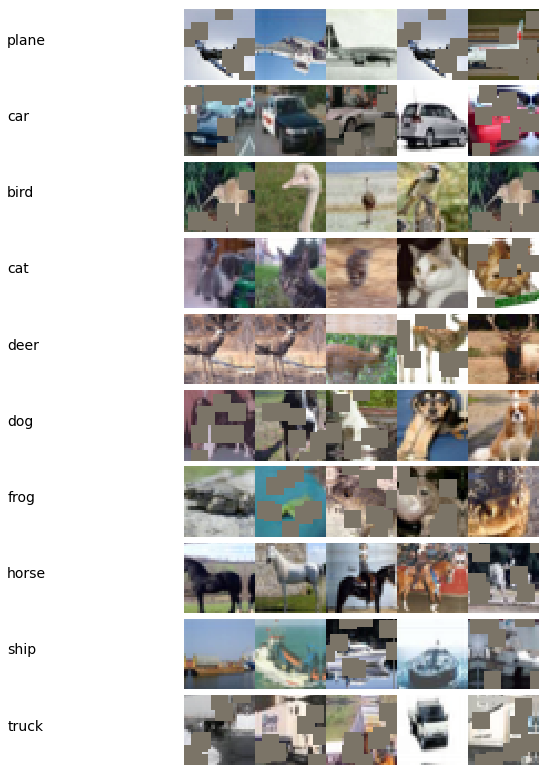

In [7]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# functions to show an image

from __future__ import print_function
def unnormalize(img):
  img = img.numpy().astype(dtype=np.float32)
  
  for i in range(img.shape[0]):
    img[i] = (img[i]*stdevs[i])+means[i]
  
  return np.transpose(img, (1,2,0))

%matplotlib inline
import matplotlib.pyplot as plt
dataiter = iter(trainloader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

num_classes = 10
 

r, c = 10, 11
n = 5
fig = plt.figure(figsize=(14,14))
fig.subplots_adjust(hspace=0.01, wspace=0.01)
for i in range(num_classes):
    idx = np.random.choice(np.where(labels[:]==i)[0], n)
    ax = plt.subplot(r, c, i*c+1)
    ax.text(-1.5, 0.5, classes[i], fontsize=14)
    plt.axis('off')
    for j in range(1, n+1):
      plt.subplot(r, c, i*c+j+1)
      plt.imshow(unnormalize(images[idx[j-1]]), interpolation='none')
      plt.axis('off')
plt.show()

In [0]:
import evamodel

net = evamodel.newResnet()

In [9]:
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = net.to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
              ReLU-2           [-1, 64, 32, 32]               0
       BatchNorm2d-3           [-1, 64, 32, 32]             128
           Dropout-4           [-1, 64, 32, 32]               0
            Conv2d-5          [-1, 128, 32, 32]          73,856
         MaxPool2d-6          [-1, 128, 16, 16]               0
              ReLU-7          [-1, 128, 16, 16]               0
       BatchNorm2d-8          [-1, 128, 16, 16]             256
           Dropout-9          [-1, 128, 16, 16]               0
           Conv2d-10          [-1, 128, 16, 16]         147,584
      BatchNorm2d-11          [-1, 128, 16, 16]             256
             ReLU-12          [-1, 128, 16, 16]               0
           Conv2d-13          [-1, 128, 16, 16]         147,584
      BatchNorm2d-14          [-1,

  pip install torch-lr-finder -v --global-option="amp"


Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


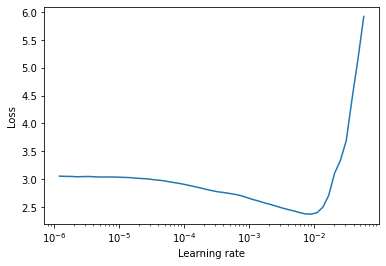

In [10]:
import sys
from torch_lr_finder import LRFinder
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-7, momentum=0.9, nesterov=True, weight_decay=1e-4)

lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(trainloader, end_lr=100, num_iter=100, step_mode="exp")
# Plot learning rate vs loss
lr_finder.plot()

# Reset graph
lr_finder.reset()

In [11]:
from torch.optim.lr_scheduler import StepLR
from torch.optim.lr_scheduler import ReduceLROnPlateau
from evascheduler import train,test
from torch.optim.lr_scheduler import OneCycleLR

model =  net.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, nesterov=True, weight_decay=1e-4)
#scheduler = ReduceLROnPlateau(optimizer, 'min')
#scheduler = StepLR(optimizer, step_size=6, gamma=0.1)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer,
                 max_lr=0.03,
                 total_steps=25,
                 epochs=25,
                 pct_start=0.2,
                 cycle_momentum=False,
                 base_momentum=0.85,
                 max_momentum=0.95,
                 div_factor=10.,
                 final_div_factor=1e4,
                 last_epoch=-1)
EPOCHS = 25
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, trainloader, optimizer, epoch,criterion)
    val = test(model, device, testloader)
    scheduler.step(val)


  0%|          | 0/98 [00:00<?, ?it/s]

EPOCH: 0


Loss=1.3934885263442993 Batch_id=97 Accuracy=41.46: 100%|██████████| 98/98 [00:25<00:00,  3.82it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.4868, Accuracy: 5132/10000 (51.32%)

EPOCH: 1


Loss=1.2909212112426758 Batch_id=97 Accuracy=53.25: 100%|██████████| 98/98 [00:25<00:00,  3.80it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.3974, Accuracy: 6026/10000 (60.26%)

EPOCH: 2


Loss=0.9608790874481201 Batch_id=97 Accuracy=60.67: 100%|██████████| 98/98 [00:25<00:00,  3.79it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.3344, Accuracy: 6656/10000 (66.56%)

EPOCH: 3


Loss=0.9780268669128418 Batch_id=97 Accuracy=64.59: 100%|██████████| 98/98 [00:25<00:00,  3.78it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.2843, Accuracy: 7157/10000 (71.57%)

EPOCH: 4


Loss=0.9577309489250183 Batch_id=97 Accuracy=67.57: 100%|██████████| 98/98 [00:25<00:00,  3.81it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.2656, Accuracy: 7344/10000 (73.44%)

EPOCH: 5


Loss=0.9138797521591187 Batch_id=97 Accuracy=69.65: 100%|██████████| 98/98 [00:25<00:00,  3.79it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.2371, Accuracy: 7629/10000 (76.29%)

EPOCH: 6


Loss=0.7989640235900879 Batch_id=97 Accuracy=71.22: 100%|██████████| 98/98 [00:25<00:00,  3.81it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.2390, Accuracy: 7610/10000 (76.10%)

EPOCH: 7


Loss=0.7269471287727356 Batch_id=97 Accuracy=72.93: 100%|██████████| 98/98 [00:25<00:00,  3.80it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.2169, Accuracy: 7831/10000 (78.31%)

EPOCH: 8


Loss=0.7333598732948303 Batch_id=97 Accuracy=74.48: 100%|██████████| 98/98 [00:26<00:00,  3.73it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.2004, Accuracy: 7996/10000 (79.96%)

EPOCH: 9


Loss=0.6274998188018799 Batch_id=97 Accuracy=75.46: 100%|██████████| 98/98 [00:26<00:00,  3.75it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.1989, Accuracy: 8011/10000 (80.11%)

EPOCH: 10


Loss=0.6025407314300537 Batch_id=97 Accuracy=76.49: 100%|██████████| 98/98 [00:25<00:00,  3.79it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.1839, Accuracy: 8161/10000 (81.61%)

EPOCH: 11


Loss=0.583958089351654 Batch_id=97 Accuracy=77.44: 100%|██████████| 98/98 [00:26<00:00,  3.74it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.1757, Accuracy: 8243/10000 (82.43%)

EPOCH: 12


Loss=0.6091387271881104 Batch_id=97 Accuracy=77.84: 100%|██████████| 98/98 [00:25<00:00,  3.79it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.1739, Accuracy: 8261/10000 (82.61%)

EPOCH: 13


Loss=0.5646519660949707 Batch_id=97 Accuracy=78.76: 100%|██████████| 98/98 [00:26<00:00,  3.73it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.1682, Accuracy: 8318/10000 (83.18%)

EPOCH: 14


Loss=0.5368857383728027 Batch_id=97 Accuracy=79.31: 100%|██████████| 98/98 [00:26<00:00,  3.77it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.1696, Accuracy: 8304/10000 (83.04%)

EPOCH: 15


Loss=0.5304642915725708 Batch_id=97 Accuracy=79.93: 100%|██████████| 98/98 [00:26<00:00,  3.75it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.1583, Accuracy: 8417/10000 (84.17%)

EPOCH: 16


Loss=0.5120154619216919 Batch_id=97 Accuracy=80.37: 100%|██████████| 98/98 [00:26<00:00,  3.76it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.1545, Accuracy: 8455/10000 (84.55%)

EPOCH: 17


Loss=0.4924840033054352 Batch_id=97 Accuracy=80.93: 100%|██████████| 98/98 [00:26<00:00,  3.76it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.1491, Accuracy: 8509/10000 (85.09%)

EPOCH: 18


Loss=0.443131685256958 Batch_id=97 Accuracy=81.32: 100%|██████████| 98/98 [00:25<00:00,  3.77it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.1518, Accuracy: 8482/10000 (84.82%)

EPOCH: 19


Loss=0.6086587905883789 Batch_id=97 Accuracy=81.79: 100%|██████████| 98/98 [00:26<00:00,  3.75it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.1496, Accuracy: 8504/10000 (85.04%)

EPOCH: 20


Loss=0.4618189334869385 Batch_id=97 Accuracy=82.16: 100%|██████████| 98/98 [00:26<00:00,  3.75it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.1464, Accuracy: 8536/10000 (85.36%)

EPOCH: 21


Loss=0.5547776222229004 Batch_id=97 Accuracy=82.73: 100%|██████████| 98/98 [00:25<00:00,  3.78it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.1417, Accuracy: 8583/10000 (85.83%)

EPOCH: 22


Loss=0.5736441016197205 Batch_id=97 Accuracy=83.11: 100%|██████████| 98/98 [00:25<00:00,  3.77it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.1443, Accuracy: 8557/10000 (85.57%)

EPOCH: 23


Loss=0.4050447344779968 Batch_id=97 Accuracy=83.31: 100%|██████████| 98/98 [00:25<00:00,  3.78it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.1409, Accuracy: 8591/10000 (85.91%)

EPOCH: 24


Loss=0.45770925283432007 Batch_id=97 Accuracy=83.66: 100%|██████████| 98/98 [00:25<00:00,  3.79it/s]



Test set: Average loss: 0.1399, Accuracy: 8601/10000 (86.01%)



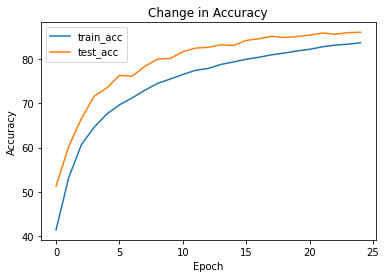

In [12]:
from evascheduler import draw_graph
draw_graph()


In [0]:
from evascheduler import get_misclassified
misclassified = get_misclassified()

25


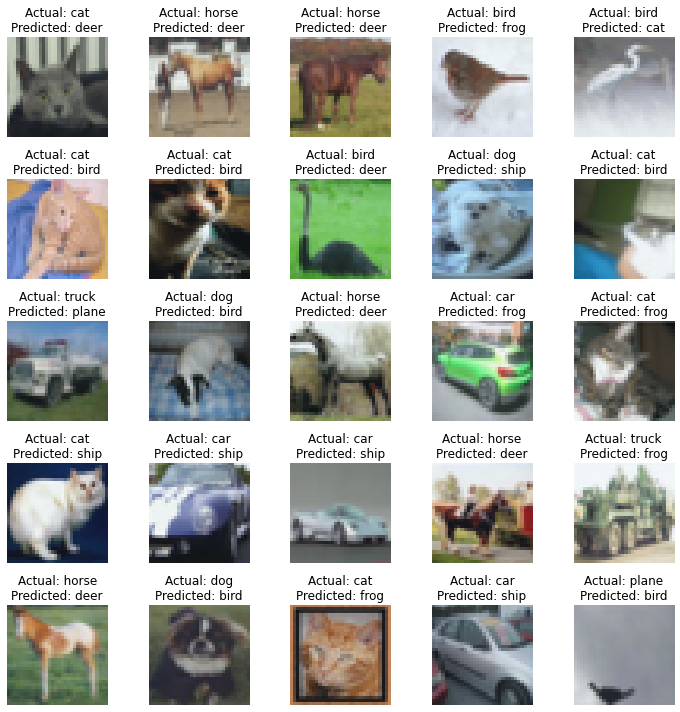

In [14]:
import utils
from utils import plot_images
plot_images(misclassified,classes,"misclassified.png")

In [0]:
model_save_name = 'models11.pt'
PATH = F"/content/drive/My Drive/EVA/S7/{model_save_name}" 
torch.save(model.state_dict(), PATH)

In [16]:
path = F"/content/drive/My Drive/EVA/S7/{model_save_name}"
model.load_state_dict(torch.load(path))

<All keys matched successfully>

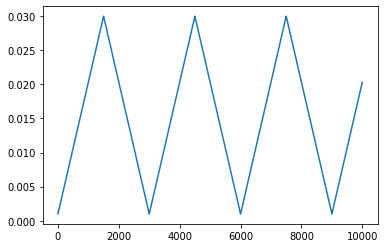

In [26]:
from utils import print_triangular_lr
num_iterations = 10000
stepsize = 1500
base_lr = 0.001
max_lr = 0.03
lr_trend = list()

for iteration in range(num_iterations):
    lr = get_triangular_lr(iteration, stepsize, base_lr, max_lr)
    lr_trend.append(lr)

plt.plot(lr_trend)